# Data processing

In [2]:
import os
import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data_folder = os.path.join(".", os.pardir, os.pardir, "data")
raw_data_folder = os.path.join(data_folder, "RAW")
processed_data_folder = os.path.join(data_folder, "processed")

print(data_folder)
print(raw_data_folder)

./../../data
./../../data/RAW


## ARotor

Kongsberg test rig

### Process

In [6]:
arotor_data_folder = os.path.join(raw_data_folder, "ARotor")

class_num = 1
class_mapping = {}

arotor_data = []

for _, dirnames, _ in os.walk(arotor_data_folder):
    for dirname in sorted(dirnames):
        print(dirname)
        for dirpath, _, filenames in os.walk(os.path.join(arotor_data_folder, dirname)):
            for filename in filenames:
                # Load file
                df_tmp = pd.read_csv(os.path.join(dirpath, filename), delimiter=";")

                # Other sensors
                 # * Cut 500 because of irregularities at end of measurements
                 # * Cut additional 2 to match encoder acceleration
                df = df_tmp.loc[:, [
                    'acc1',
                    'acc2',
                    'acc3',
                    'acc4',
                    'torque1',
                    'torque2']].iloc[:-502, :]

                # Encoders
                 # * Cut 500 because of irregularities at end of measurements
                df_enc_tmp = df_tmp.loc[:, [
                    'en1time',
                    'en1angle',
                    'en2time',
                    'en2angle',
                    'en3time',
                    'en3angle',
                    'en4time',
                    'en4angle',
                    'en5time',
                    'en5angle']].iloc[:-500, :]

                # Transform encoders data to speed and acceleration
                df_enc = []
                for i in range(1, 6):
                    a_speed = np.diff(df_enc_tmp[f"en{i}angle"]) / np.diff(df_enc_tmp[f"en{i}time"])
                    a_acc = np.diff(a_speed) / np.diff(df_enc_tmp[f"en{i}time"][:-1])

                    df_enc.append(pd.DataFrame({f"en{i}speed": a_speed[:-1], f"en{i}acc": a_acc}))
                df_enc = pd.concat(df_enc, axis=1)

                # Combine sensors data
                df = pd.concat([df, df_enc], axis=1)

                # Add rpm and class info
                info = filename.split("rpm")
                df["rpm"] = int(info[0])

                if "no_sim" in dirname:
                    df["class"] = 0
                    class_mapping[dirname.replace("_csv", "")] = 0
                else:
                    df["class"] = class_num
                    class_mapping[dirname.replace("_csv", "")] = class_num

                arotor_data.append(df)
        if not "no_sim" in dirname:
            class_num += 1
        
arotor_data = pd.concat(arotor_data)
arotor_data = arotor_data.reset_index(drop=True)

# * Cut 500 last samples from all sensors because of irregularities


# Swap acceloremeters 2 and 4
arotor_data[["acc2", "acc4"]] = arotor_data[["acc4", "acc2"]]

print()
print("Class mapping:")
pprint.pprint(class_mapping)

001_1sim_csv
001_2sim_csv
001_3sim_csv
003_1sim_csv
003_2sim_csv
003_3sim_csv
005_1sim_csv
005_2sim_csv
005_3sim_csv
no_sim_csv

Class mapping:
{'001_1sim': 1,
 '001_2sim': 2,
 '001_3sim': 3,
 '003_1sim': 4,
 '003_2sim': 5,
 '003_3sim': 6,
 '005_1sim': 7,
 '005_2sim': 8,
 '005_3sim': 9,
 'no_sim': 0}


In [7]:
# Show processed data shape

arotor_data.head()

,acc1,acc2,acc3,acc4,torque1,torque2,en1speed,en1acc,en2speed,en2acc,en3speed,en3acc,en4speed,en4acc,en5speed,en5acc,rpm,class
0,1.837953,1.645023,1.873710,0.695454,0.942261,3.973999,6034.573072,-26302.613834,6049.058588,-207012.667093,1979.491753,29927.754728,-1978.928081,-35599.298988,496.856310,4453.003403,1000,1
1,-0.786764,-2.787747,-4.137097,-6.515445,0.722656,3.989563,6025.786026,-51919.604088,5980.066441,135339.960417,1989.560946,87763.778620,-1990.585071,21262.784827,498.308212,8843.856863,1000,1
2,-1.084027,0.395010,-0.497809,0.072936,1.012451,3.995972,6008.570783,98345.016953,6024.877502,-243397.190840,2018.145608,-37546.821533,-1983.471075,-29985.498103,501.183350,5569.745715,1000,1
3,3.178846,0.819396,2.087222,-7.280841,0.734131,3.926392,6041.272960,-138405.279894,5944.160908,216449.291006,2005.420052,38427.482052,-1993.539456,-34228.749506,503.183724,-7007.548986,1000,1
4,-0.377739,-1.216127,-0.765620,-5.330565,1.072510,3.825378,5995.498874,138727.050629,6016.260167,106999.309197,2018.181819,-33635.672501,-2004.665511,-59903.998826,500.927644,-5488.468933,1000,1


In [10]:
arotor_data.groupby(["rpm", "class"]).first()

acc1      acc2      acc3      acc4   torque1    torque2  \
rpm  class                                                                
250  0     -0.192631 -0.154310 -0.248390 -1.462964  0.467285   2.574158   
     1      0.123867  0.226329  0.115036  0.809872  0.574585   3.626404   
     2     -0.656815 -0.042250 -0.000543  0.220585  0.718872   4.233093   
     3      0.131988 -0.102686  0.111050  0.586256  0.681763   4.567871   
     4     -0.138294 -0.172928  0.056844  0.122894  0.628174   3.114624   
     5     -0.147631 -0.060830 -0.251683 -1.220955  0.619263   4.122314   
     6     -0.026027 -0.132811 -0.080102  0.732502  0.729004   4.586792   
     7      0.135599 -0.124934  0.063281 -1.603840  0.529907   2.978516   
     8     -0.318800  0.019366 -0.317958 -1.097480  0.665283   3.689575   
     9     -0.035832 -0.083320  0.240419  0.485553  0.422607   2.305603   
500  0      0.644896  0.379498  0.578659 -5.106649  0.529907   2.779541   
     1     -0.320203 -0.226030  0.233084  3.211871  0.721436   3.215637   
     2     -0.892220  1.083915 -0.504713 -3.372356  0.686890   2.956543   
     3     -0.499174  0.285962 -2.071879 -6.028133  0.647339   3.439941   
     4     -0.084499 -2.218986  1.199081  3.143276  0.789062   3.711548   
     5     -0.049266  0.510850  0.375737  1.118437  0.814575   4.931335   
     6      0.042530 -0.324226 -0.326247  5.272018  1.216797   7.161865   
     7     -0.336257  0.482896  0.154198  0.879814  0.513306   1.215515   
     8      0.332552  0.848249  0.848454  4.039182  0.786499   1.642151   
     9      0.006530 -0.035682  0.153337  4.876222  0.555420   3.458862   
750  0     -1.306333 -0.867502 -1.296772  6.191967  0.863159   2.940674   
     1     -0.454418 -2.434444 -0.226311  2.929726  0.979370   3.433533   
     2      0.520973  2.114671  0.022322  0.593647  0.528564   2.277222   
     3     -2.109732 -0.602422 -2.597099 -1.236017  0.859253   5.777893   
     4     -0.780271  0.125776 -0.066200 -2.368674  0.457153   3.174438   
     5      0.229753  0.033212  0.645701  1.681510  1.067383   5.260010   
     6     -1.682221  1.369783 -0.813483  2.078278  0.588623   4.858704   
     7     -1.108389 -0.001123 -3.490685  0.786371  0.727783   1.667480   
     8      1.302198  1.113422  2.320287 -1.989344  0.485229   0.005493   
     9      0.285774 -0.295355 -0.237874  3.322042  0.915527   6.950378   
1000 0      1.144464 -0.957802  1.963037 -6.481971  0.713745   3.395691   
     1      1.837953  1.645023  1.873710  0.695454  0.942261   3.973999   
     2      1.957854 -2.321167  0.739406  6.577379  0.956299   4.353027   
     3      1.492453 -3.598573  1.559625  6.761533  1.599854   6.602783   
     4     -0.350328  2.129060  0.238454 -0.113558  0.772461   3.171387   
     5     -0.746236 -1.336383 -0.144468 -0.696520  1.193848   4.830017   
     6      0.784575 -2.294260  1.343999  3.375892  1.275513   5.297852   
     7     -0.735402  0.993634 -0.283136 -5.940172  1.039307   2.984924   
     8     -0.028591  0.089177 -2.876961 -3.040889  0.460938   1.380005   
     9     -1.031542 -0.900733 -0.389228 -5.889914  1.680298   7.964478   
1250 0      1.859695  2.459741  2.819462  8.170684  0.928223   2.195129   
     1     -0.030574  1.281953 -7.068002 -4.172929  0.823486   5.983276   
     2     -2.343807  2.087765 -0.057349 -8.171676  1.175903   2.258301   
     3      6.430590  1.672453  0.716672  7.716622  1.083984   4.371948   
     4      0.600495 -1.382619  1.035678  9.816699  1.016357   6.296082   
     5     -0.609944  0.785903 -0.979002  9.357210  0.826050   5.193481   
     6     -1.850340  2.123054 -0.484973  7.477176  1.898560   9.506226   
     7     -0.736019  0.107701  0.772525  7.436386  1.366211   7.894897   
     8      4.135544 -6.080767  5.166712 -7.619081  1.029053   2.694397   
     9      0.042736  2.505808 -0.232485 -8.113971  0.464722   3.689575   
1500 0      2.363398 -2.410662 -3.076066  4.820463  0.983154   4.504700   
     1     -0.452490 -2.244975 -2.417454 

In [63]:
list(zip([1, 2, 3], np.repeat(3, 3)))

[(1, 3), (2, 3), (3, 3)]

In [9]:
# Save processed data

arotor_data.to_feather(os.path.join(processed_data_folder, "arotor.feather"))

In [58]:
np.repeat([1,2,3], 3)

array([1, 1, 1, 2, 2, 2, 3, 3, 3])

### ARotor checks

In [32]:
data_500_3x1mm = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "001_3sim_csv", "250rpm_001_3sim_0.csv"), delimiter=";")
data_250_2x3mm = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "003_2sim_csv", "250rpm_0030_2sim_new_0.csv"), delimiter=";")
data_1500_3x5mm = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "005_3sim_csv", "1500rpm_0050_3sim_0.csv"), delimiter=";")

### Crude check

**Note:** Some of the measurements seem to have irregularities or something at the end.

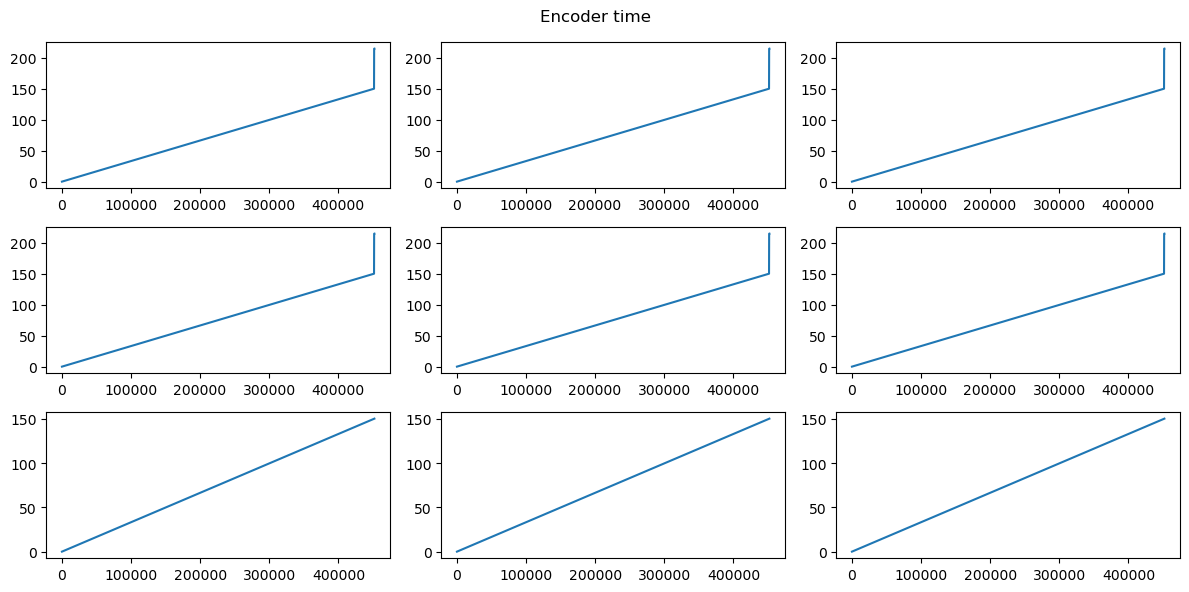

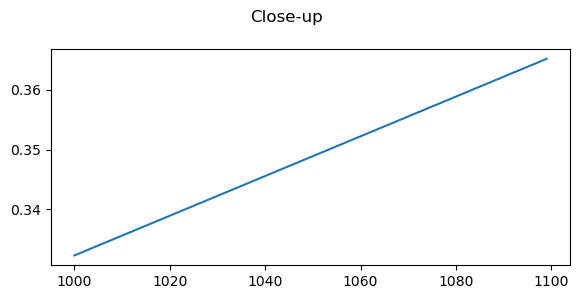

In [81]:
# Check encoder data

fig, axs = plt.subplots(3, 3, figsize=(12, 6))
axs = axs.flatten()

fig.suptitle("Encoder time")

for i, d in enumerate([data_500_3x1mm, data_250_2x3mm, data_1500_3x5mm]):
    axs[i * 3].plot(d["en1time"])
    axs[i * 3 + 1].plot(d["en3time"])
    axs[i * 3 + 2].plot(d["en5time"])

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(6, 3))
fig.suptitle("Close-up")

plt.plot(data_500_3x1mm["en1time"][1000:1100])
plt.tight_layout()
plt.show()

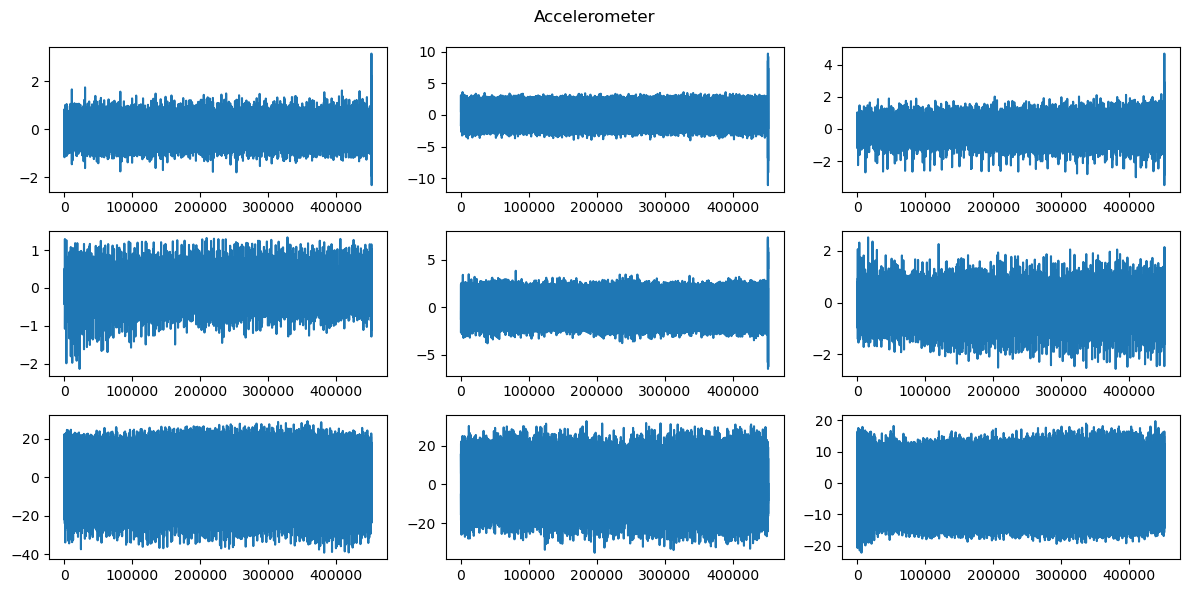

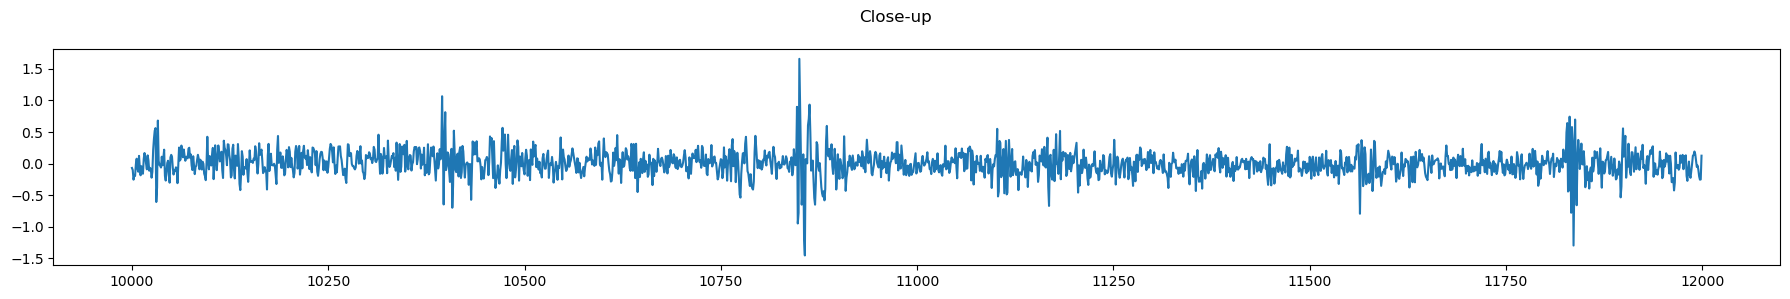

In [80]:
# Check accelerometer data

fig, axs = plt.subplots(3, 3, figsize=(12, 6))
axs = axs.flatten()

fig.suptitle("Accelerometer")

for i, d in enumerate([data_500_3x1mm, data_250_2x3mm, data_1500_3x5mm]):
    axs[i * 3].plot(d["acc1"])
    axs[i * 3 + 1].plot(d["acc2"])
    axs[i * 3 + 2].plot(d["acc4"])

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(18, 3))
fig.suptitle("Close-up")

plt.plot(data_500_3x1mm["acc1"][10000:12000])
plt.tight_layout()
plt.show()

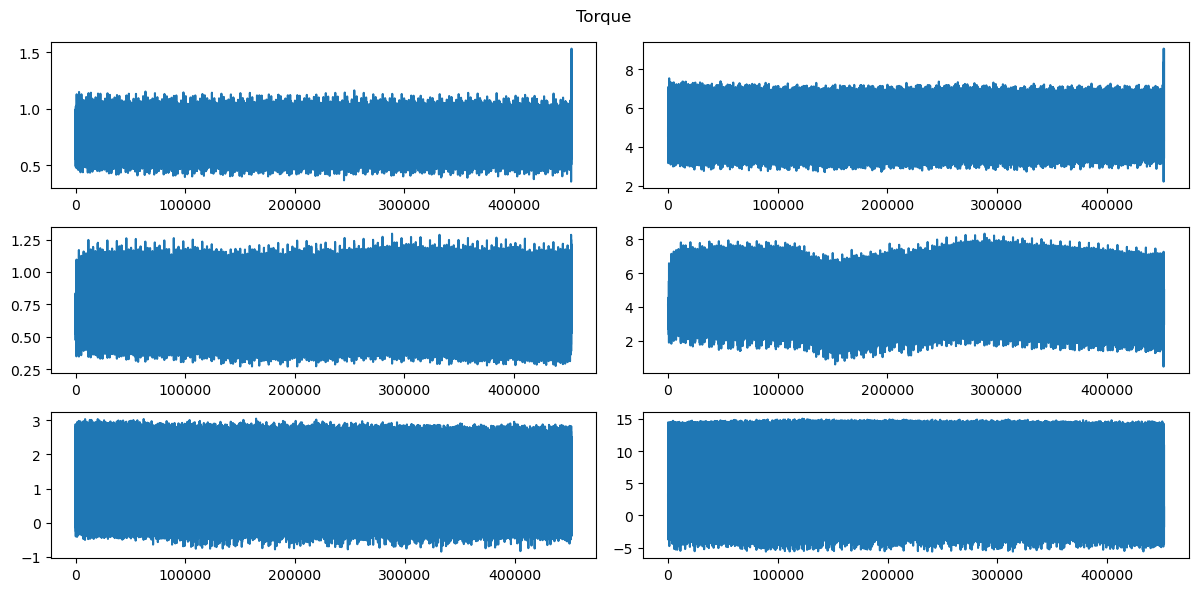

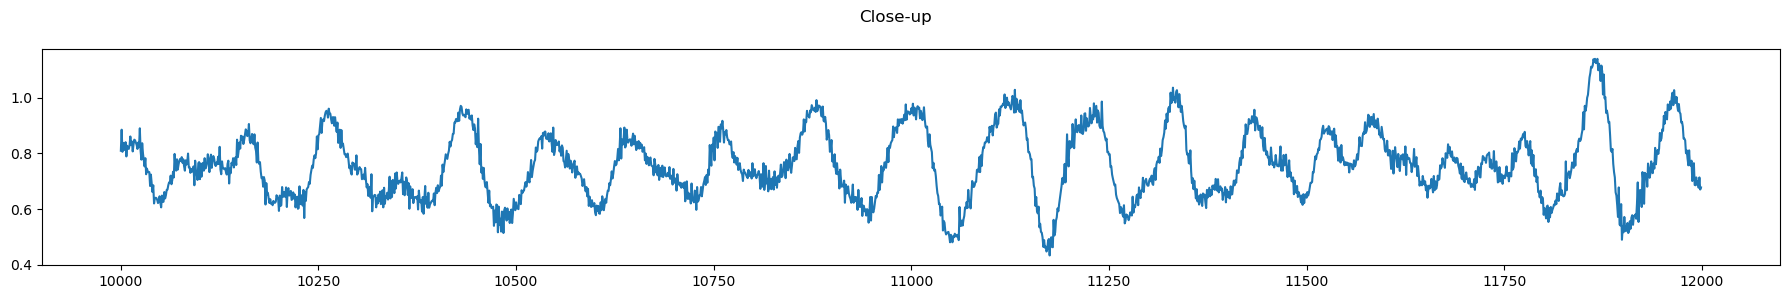

In [79]:
# Check torque data

fig, axs = plt.subplots(3, 2, figsize=(12, 6))
axs = axs.flatten()

fig.suptitle("Torque")

for i, d in enumerate([data_500_3x1mm, data_250_2x3mm, data_1500_3x5mm]):
    axs[i * 2].plot(d["torque1"])
    axs[i * 2 + 1].plot(d["torque2"])

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(18, 3))
fig.suptitle("Close-up")

plt.plot(data_500_3x1mm["torque1"][10000:12000])
plt.tight_layout()
plt.show()

### Fixes

Remove the irregularities. This was used to determine the amount to cut of the samples for the processing above. Seems like dropping 500 measurement samples is enough.

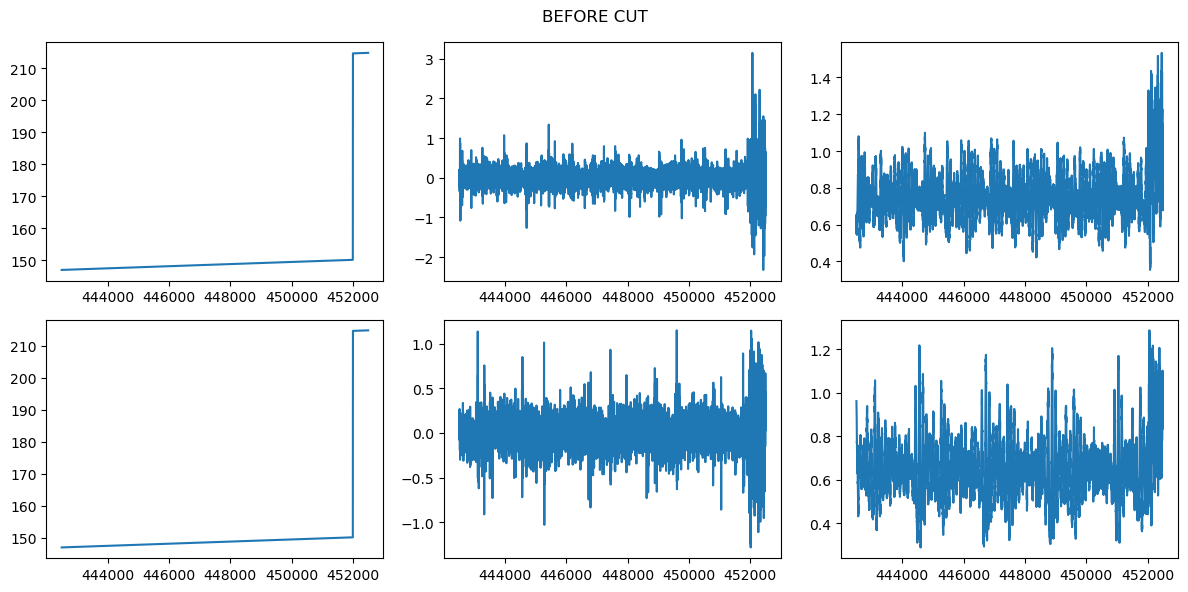

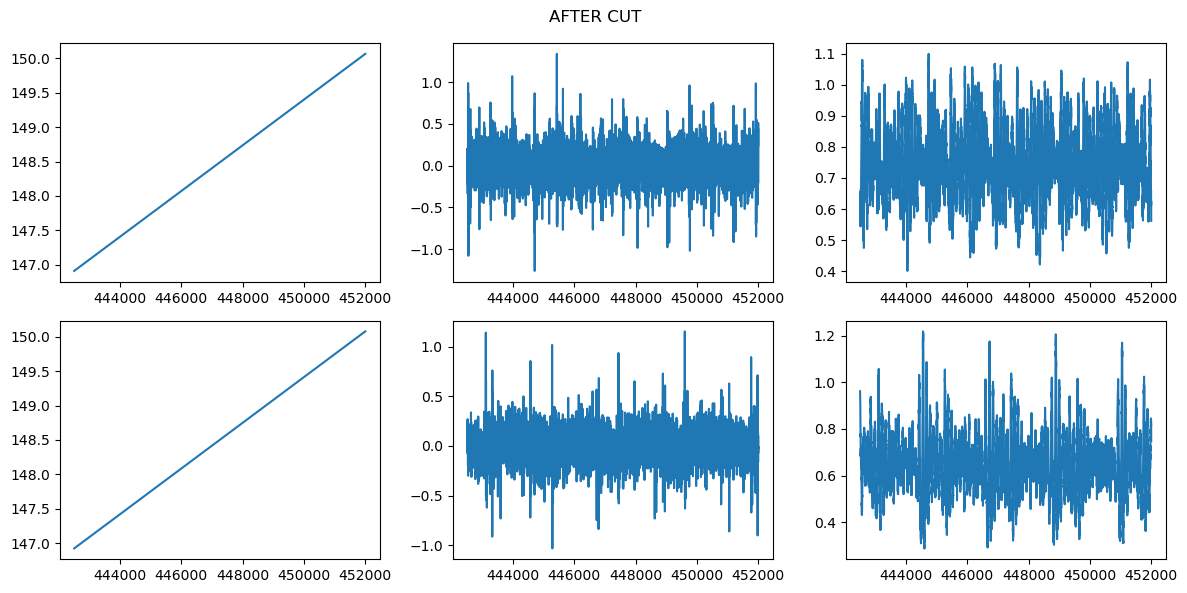

In [78]:
# BEFORE CUT

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs = axs.flatten()

fig.suptitle("BEFORE CUT")

for i, d in enumerate([data_500_3x1mm, data_250_2x3mm]):
    axs[i * 3].plot(d["en1time"][-10000:])
    axs[i * 3 + 1].plot(d["acc1"][-10000:])
    axs[i * 3 + 2].plot(d["torque1"][-10000:])


plt.tight_layout()

# AFTER CUT

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs = axs.flatten()

fig.suptitle("AFTER CUT")

cut = 500

for i, d in enumerate([data_500_3x1mm, data_250_2x3mm]):
    axs[i * 3].plot(d["en1time"][-10000:-cut])
    axs[i * 3 + 1].plot(d["acc1"][-10000:-cut])
    axs[i * 3 + 2].plot(d["torque1"][-10000:-cut])

plt.tight_layout()